## 0. Datasets and models

### 0.1 cMNIST

The first experiments were conducted on an augmented version of MNIST. Each original picture was multiplied with a random contrast variable ($c\in[0,1])$.

The models' latent space have 10 dimensions, and a 3-dimensional variant was used for visualization. The models use ReLU nonlinearity in the encoder and the decoder part as well.

The Scale Mixtures VAE (SMVAE) has a multiplicative inductive bias: one of the latent variables multiplies the decoded value of the others. The latents are [z, c] (where $c \in \R$), and the output is given by *c*Decoder(z).* 

- Structural details about the MNIST SMVAE
    
    Several models were tested. Multiplication *before* the decoder (*Decoder(c*z))* didn’t work well due to the nonlinear nature. 
    
    Hence the model’s output was given by multiplying the decoder’s output: $c\cdot Decoder(z)$. 
    
    *(Here $Decoder(z) \in [0,1]$, meaning the multiplication was done* after *the sigmoid layer, differently than in EA-VAE (arxiv p.10.))*
    
    Two transformations of the Normal distribution were tested for the contrast variable prior. Both gave good results. 
    
    p(c) ~ Lognormal: the latent variable gets exponentialized before the multiplication: $\exp(c)\cdot Decoder(z)$. *(It could be interesting to test this with before-sigmoid-multiplication)*
    
    p(c) ~ Logitnormal: the latent variable goes through a sigmoid function: $Sigmoid(c)\cdot Decoder(z)$. *(Because Decoder(z) was already on [0,1])*
    

### 0.2 cFashionMNIST

Same contrast augmentation for this dataset, so each original picture was multiplied with a random contrast variable ($c\in[0,1])$. 10 dimensions latents for both models.

The contrast ground truth value was chosen to be the *average value of non-zero pixels* instead of the multiplying $c$, because of the dataset characteristics. 

The same models are used as in case of cMNIST.

In [2]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid

path = '../smvae_data/'

In [21]:
mnist_vanilla_3d_rec = pickle.load(open(path+'mnist_vanilla/3d/mnist_vanilla_reconstruction.pkl', 'rb'))
mnist_vanilla_10d_rec = pickle.load(open(path+'mnist_vanilla/10d/mnist_vanilla_reconstruction.pkl', 'rb'))
mnist_smvae_3d_rec = pickle.load(open(path+'mnist_smvae/3d/mnist_smvae_reconstruction.pkl', 'rb'))
mnist_smvae_10d_rec = pickle.load(open(path+'mnist_smvae/10d/mnist_smvae_reconstruction.pkl', 'rb'))
fashion_vanilla_rec = pickle.load(open(path+'fashion_vanilla/fashion_vanilla_reconstruction.pkl', 'rb'))
fashion_smvae_rec = pickle.load(open(path+'fashion_smvae/fashion_smvae_reconstruction.pkl', 'rb'))

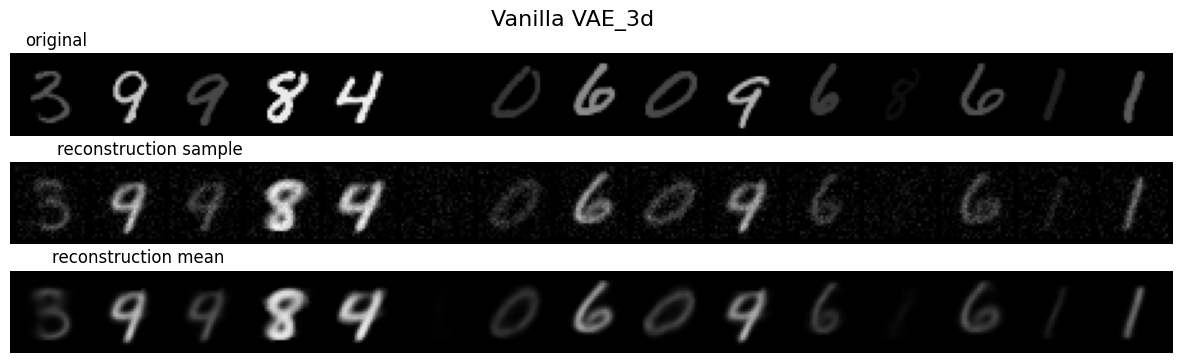

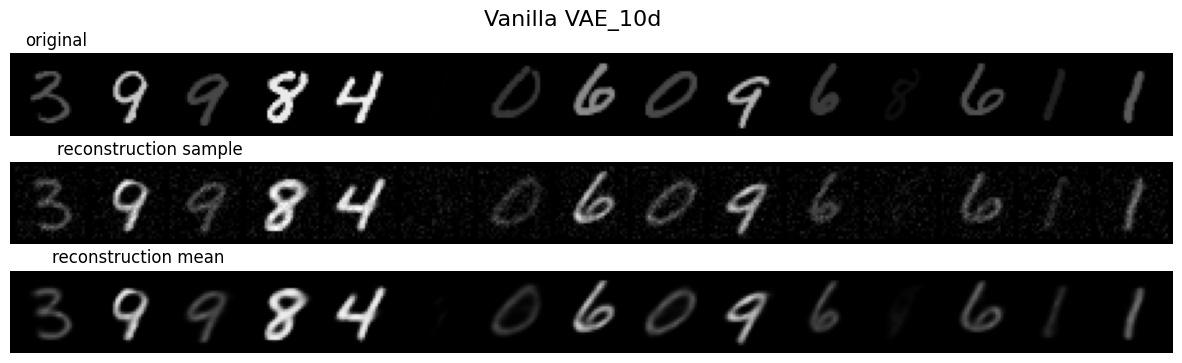

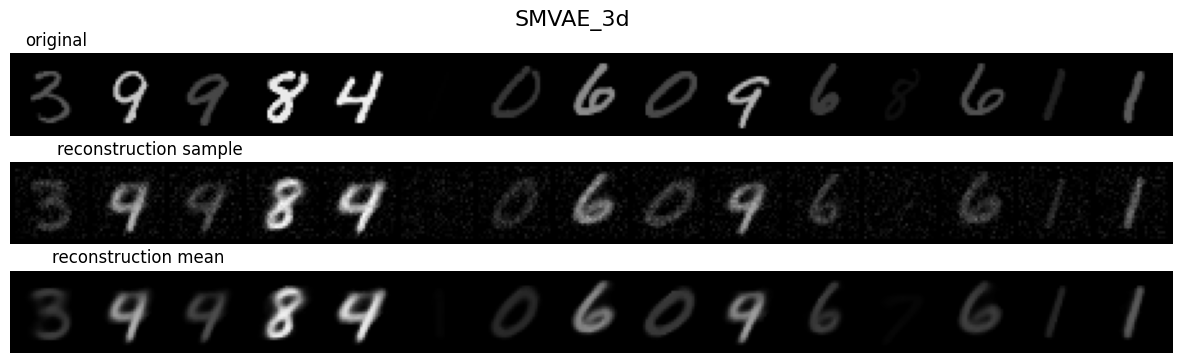

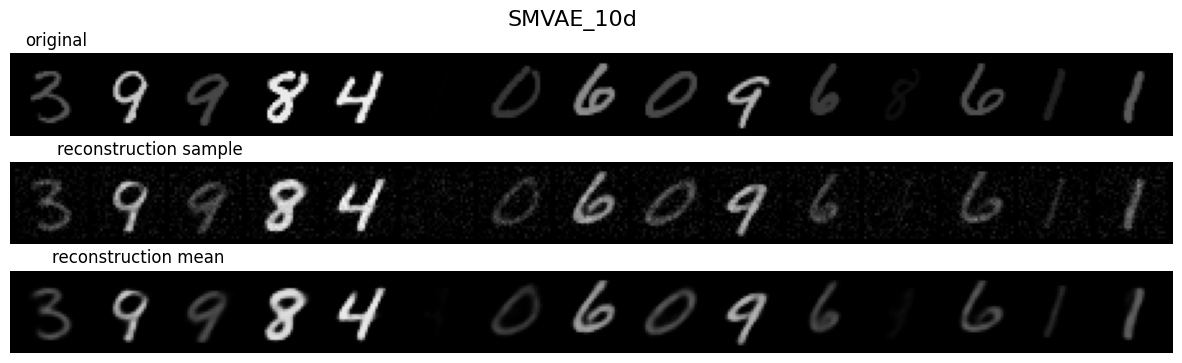

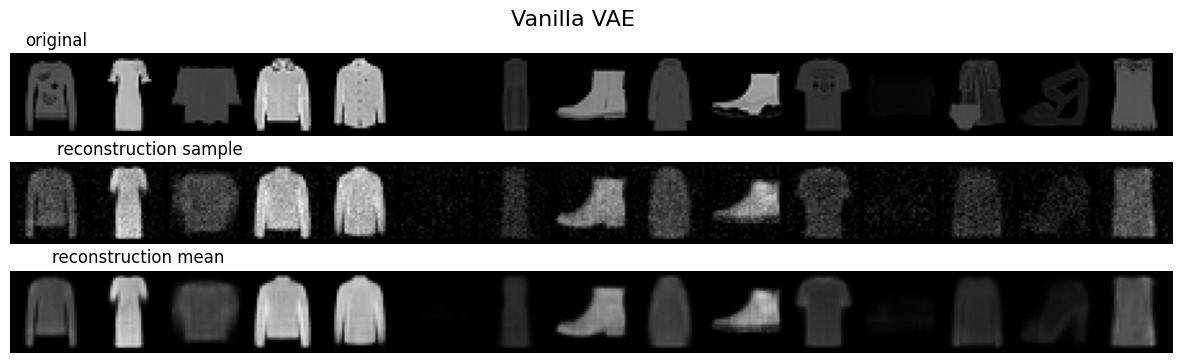

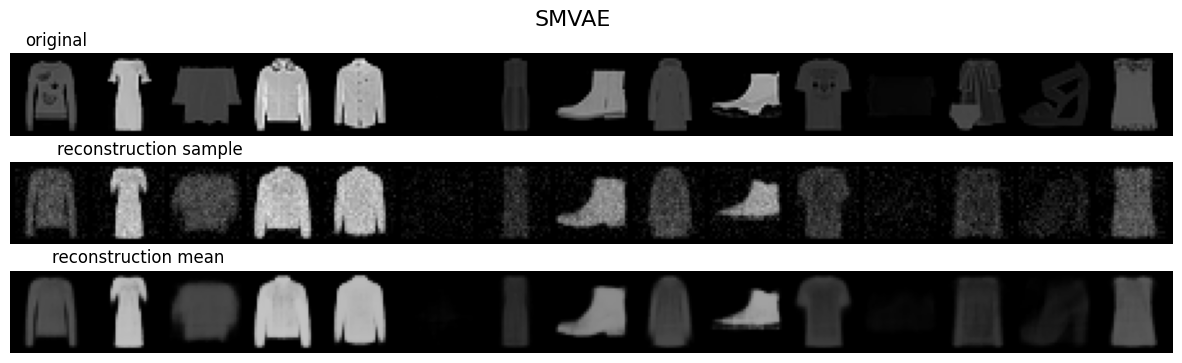

In [22]:
def compare(rec_data, n, title='Title'):
    # rec_data = (original, reconstruction_sample, reconstruction_mean)

    fig, axs = plt.subplots(3, figsize=(n,4))
    fig.suptitle(title, fontsize=16)# y=0.1)
    axs[0].set_title('original', x=0.04)#, ha='left')
    axs[1].set_title('reconstruction sample', x=0.12)
    axs[2].set_title('reconstruction mean', x=0.11)
    
    to_pil = transforms.ToPILImage()

    for i, ax in enumerate(axs):
        ax.axis('off')
        ax.imshow(to_pil(make_grid(rec_data[i][:n], nrow=n, padding=2, normalize=True, value_range=(0, 1))))

    plt.show()

n_images = 15
compare(mnist_vanilla_3d_rec, n_images, 'Vanilla VAE_3d')
compare(mnist_vanilla_10d_rec, n_images, 'Vanilla VAE_10d')
compare(mnist_smvae_3d_rec, n_images, 'SMVAE_3d')
compare(mnist_smvae_10d_rec, n_images, 'SMVAE_10d')
compare(fashion_vanilla_rec, n_images, 'Vanilla VAE')
compare(fashion_smvae_rec, n_images, 'SMVAE')

**Change of representation**

In [23]:
mnist_contrast = pickle.load(open(path+'mnist_vanilla/10d/mnist_vanilla_contrast.pkl', 'rb'))
mnist_vanilla_post_mean = pickle.load(open(path+'mnist_vanilla/10d/mnist_vanilla_posterior_mean.pkl', 'rb'))
mnist_vanilla_post_std = pickle.load(open(path+'mnist_vanilla/10d/mnist_vanilla_posterior_std.pkl', 'rb'))
mnist_smvae_post_mean = pickle.load(open(path+'mnist_smvae/10d/mnist_smvae_posterior_mean.pkl', 'rb'))
mnist_smvae_post_std = pickle.load(open(path+'mnist_smvae/10d/mnist_smvae_posterior_std.pkl', 'rb'))

fashion_contrast = pickle.load(open(path+'fashion_vanilla/fashion_vanilla_contrast.pkl', 'rb'))
fashion_vanilla_post_mean = pickle.load(open(path+'fashion_vanilla/fashion_vanilla_posterior_mean.pkl', 'rb'))
fashion_vanilla_post_std = pickle.load(open(path+'fashion_vanilla/fashion_vanilla_posterior_std.pkl', 'rb'))
fashion_smvae_post_mean = pickle.load(open(path+'fashion_smvae/fashion_smvae_posterior_mean.pkl', 'rb'))
fashion_smvae_post_std = pickle.load(open(path+'fashion_smvae/fashion_smvae_posterior_std.pkl', 'rb'))


In [24]:
def get_correlations(contrast, latent_posterior_mean):
    latent_size = latent_posterior_mean.shape[1]
    correlations = torch.zeros(latent_size)
    for i in range(latent_size):
        current_data = torch.stack((contrast, latent_posterior_mean[:, i]))
        corr = torch.corrcoef(current_data)
        correlations[i] = corr[0, 1]
    return correlations

mnist_vanilla_corr = get_correlations(mnist_contrast, mnist_vanilla_post_mean)
mnist_smvae_corr = get_correlations(mnist_contrast, mnist_smvae_post_mean)
fashion_vanilla_corr = get_correlations(fashion_contrast, fashion_vanilla_post_mean)
fashion_smvae_corr = get_correlations(fashion_contrast, fashion_smvae_post_mean)

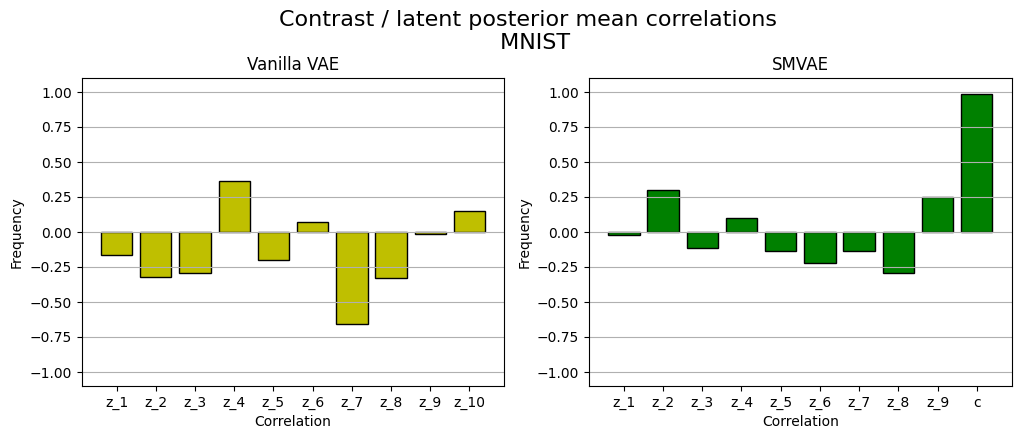

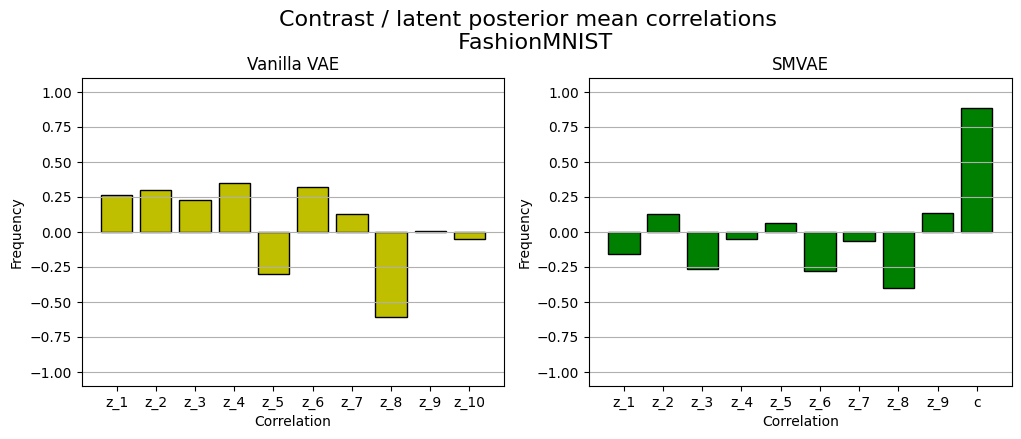

In [25]:
def barplot_correlations(corr_list, colors, dataset_name):
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    axs[0].set_title('Vanilla VAE')
    axs[1].set_title('SMVAE')

    for i, ax in enumerate(axs):
        labels = [f'z_{i+1}' for i in range(9)] 
        labels.append('z_10') if 'SMVAE' not in axs[i].get_title() else labels.append('c')
        ax.bar([i for i in range(10)], corr_list[i], edgecolor='black', color=colors[i], tick_label=labels)
        ax.set_xlabel('Correlation')
        ax.set_ylabel('Frequency')
        ax.grid(axis='y')
        ax.set_ylim(-1.1, 1.1)

    plt.suptitle(f'Contrast / latent posterior mean correlations \n {dataset_name}', fontsize=16, y=1.05)
    plt.show()

barplot_correlations([mnist_vanilla_corr, mnist_smvae_corr], ['y', 'g'], 'MNIST')
barplot_correlations([fashion_vanilla_corr, fashion_smvae_corr], ['y', 'g'], 'FashionMNIST')

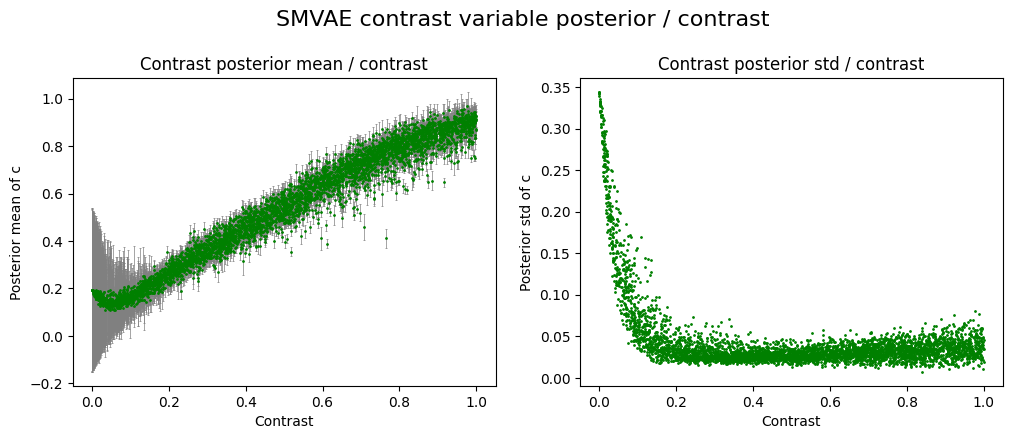

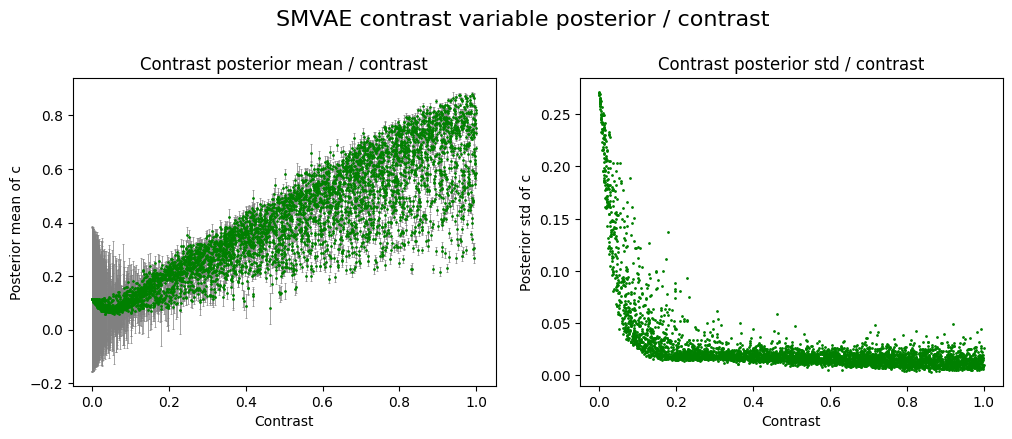

In [26]:
mnist_c_post_mean = mnist_smvae_post_mean[:, -1]
mnist_c_post_std = mnist_smvae_post_std[:, -1]
fashion_c_post_mean = fashion_smvae_post_mean[:, -1]
fashion_c_post_std = fashion_smvae_post_std[:, -1]

def plot_contrasts(contrast, post_mean, post_std, colors=['y', 'g']):
    fig, axs = plt.subplots(1, 2, figsize=(12,4))

    axs[0].scatter(contrast, post_mean, s=1, c=colors[1])
    axs[0].set_xlabel('Contrast')
    axs[0].set_ylabel('Posterior mean of c')
    axs[0].set_title('Contrast posterior mean / contrast')
    axs[0].errorbar(contrast, post_mean, yerr=post_std, c='grey', fmt='none', capsize=1, elinewidth=0.5, capthick=0.5, zorder=0)
    #bottom, top = axs[0].get_ylim()  # return the current ylim
    #axs[0].set_ylim(bottom, top)   # set the ylim to bottom, top

    axs[1].scatter(contrast, post_std, s=1, c=colors[1])
    axs[1].set_xlabel('Contrast')
    axs[1].set_ylabel('Posterior std of c')
    axs[1].set_title('Contrast posterior std / contrast')
    #axs[1].set_ylim(0, 0.1)

    plt.suptitle('SMVAE contrast variable posterior / contrast', fontsize=16, y=1.05)
    plt.show()

plot_contrasts(mnist_contrast, mnist_c_post_mean, mnist_c_post_std)
plot_contrasts(fashion_contrast, fashion_c_post_mean, fashion_c_post_std)